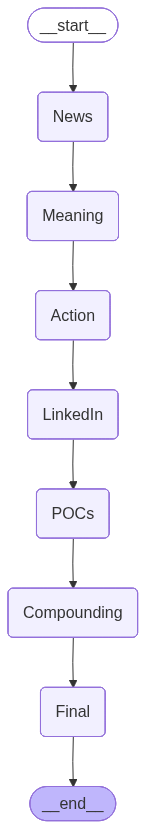

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://fcb7d6bda905d63794.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict
from langchain_core.runnables import RunnableLambda
import gradio as gr
from IPython.display import Image, display

# LLM
llm = ChatOpenAI(model="gpt-4o")

# Estado
class State(TypedDict):
    task: str
    lang: str  # "es" or "en"
    news: str
    meaning: str
    action: str
    linkedin_post: str
    poc_ideas: str
    compounding: str
    final_summary: str

# Helper para idioma
def lang_prefix(lang: str, es: str, en: str):
    return es if lang == "es" else en

# Nodo: Noticias
def news_agent(state: State) -> State:
    prompt = f"""{lang_prefix(state['lang'],
    "Sos un analista de IA. Extraé las 3–5 noticias más recientes sobre IA (OpenAI, Anthropic, DeepMind, open-source, enterprise). Redactá en lenguaje claro y útil, sin inventar.",
    "You are an AI analyst. Extract 3–5 of the most recent AI news (OpenAI, Anthropic, DeepMind, open-source, enterprise adoption). Write clearly and practically, no fabrication.")}

Task: {state['task']}
"""
    result = llm.invoke(prompt)
    state["news"] = result.content
    return state

# Nodo: Significado
def meaning_agent(state: State) -> State:
    prompt = f"""{lang_prefix(state['lang'],
    "Sos un coach de carrera para un Tech Lead .NET + AWS + constructor de agentes LLM. Explicá cómo cada noticia representa una oportunidad real en sectores de banca, seguros, salud, travel, energía.",
    "You are a career coach for a Tech Lead .NET + AWS + LLM agents builder. Explain how each news translates into real opportunities in finance, insurance, healthcare, travel, energy.")}

Noticias:
{state['news']}
"""
    result = llm.invoke(prompt)
    state["meaning"] = result.content
    return state

# Nodo: Acción diaria
def action_agent(state: State) -> State:
    prompt = f"""{lang_prefix(state['lang'],
    "Proponé una micro-acción diaria (≤15 min) que acerque al usuario a oportunidades globales. Algo concreto y ejecutable hoy (ej. post corto, DM, pitch, probar repo).",
    "Suggest one micro-action (≤15 min) that brings the user closer to global opportunities. Must be concrete and executable today (e.g., short LinkedIn post, DM, pitch snippet, test repo).")}"""
    result = llm.invoke(prompt)
    state["action"] = result.content
    return state

# Nodo: LinkedIn Post
def linkedin_agent(state: State) -> State:
    prompt = f"""Generate 2 LinkedIn posts ({lang_prefix(state['lang'], "uno en español y uno en inglés", "one in English and one in Spanish")}),
style: authoritative, inspiring, not egocentric. Goal: attract inbound high-value leads (+10K/month, no micromanagement).

Context:
{state['news']}
Meaning:
{state['meaning']}
Daily Action:
{state['action']}
"""
    result = llm.invoke(prompt)
    state["linkedin_post"] = result.content
    return state

# Nodo: POCs (opcional)
def poc_agent(state: State) -> State:
    prompt = f"""{lang_prefix(state['lang'],
    "Generá 3 ideas de POC simples (45 min) conectadas a las noticias. Ej: .NET API + LLM, middleware de seguridad, extractor de facturas, workflow agent.",
    "Generate 3 simple POC ideas (45 min) connected to the news. Ex: .NET API + LLM, safety middleware, invoice extractor, workflow agent.")}

Noticias:
{state['news']}
"""
    result = llm.invoke(prompt)
    state["poc_ideas"] = result.content
    return state

# Nodo: Compounding
def compounding_agent(state: State) -> State:
    prompt = f"""{lang_prefix(state['lang'],
    "Explicá cómo el post, la acción y los POCs se acumulan estratégicamente hacia oportunidades globales de consultoría (+10K/month).",
    "Explain how the LinkedIn post, action, and POCs accumulate strategically toward global consulting opportunities (+10K/month).")}

Acción:
{state['action']}
Post:
{state['linkedin_post']}
POCs:
{state['poc_ideas']}
"""
    result = llm.invoke(prompt)
    state["compounding"] = result.content
    return state

# Nodo: Resumen final
def final_summary(state: State) -> State:
    prompt = f"""{lang_prefix(state['lang'],
    "📋 Resumen Final de la Lectura de Hoy",
    "📋 Final Summary of Today's Reading")}

📰 Noticias:
{state['news']}

💡 Oportunidades:
{state['meaning']}

⚡ Acción diaria:
{state['action']}

🔗 Post LinkedIn:
{state['linkedin_post']}

🛠️ POCs:
{state['poc_ideas']}

📈 Compounding:
{state['compounding']}
"""
    result = llm.invoke(prompt)
    state["final_summary"] = result.content
    return state

# Construcción del grafo
builder = StateGraph(State)
builder.add_node("News", RunnableLambda(news_agent))
builder.add_node("Meaning", RunnableLambda(meaning_agent))
builder.add_node("Action", RunnableLambda(action_agent))
builder.add_node("LinkedIn", RunnableLambda(linkedin_agent))
builder.add_node("POCs", RunnableLambda(poc_agent))
builder.add_node("Compounding", RunnableLambda(compounding_agent))
builder.add_node("Final", RunnableLambda(final_summary))

builder.set_entry_point("News")
builder.add_edge("News", "Meaning")
builder.add_edge("Meaning", "Action")
builder.add_edge("Action", "LinkedIn")
builder.add_edge("LinkedIn", "POCs")
builder.add_edge("POCs", "Compounding")
builder.add_edge("Compounding", "Final")
builder.add_edge("Final", END)

graph = builder.compile(checkpointer=MemorySaver())
display(Image(graph.get_graph().draw_mermaid_png()))

# Interfaz Gradio
def run_pipeline(task, lang):
    result = graph.invoke({"task": task, "lang": lang}, config={"configurable": {"thread_id": "gradio-run"}})
    return (
        result["news"],
        result["meaning"],
        result["action"],
        result["linkedin_post"],
        result["poc_ideas"],
        result["compounding"],
        result["final_summary"]
    )

with gr.Blocks() as demo:
    gr.Markdown("## 🌍 Daily AI Career Coach (10-min Reading)")
    task_input = gr.Textbox(label="📌 Extra details (optional, e.g., sector focus)", lines=3)
    lang_input = gr.Radio(["es", "en"], label="🌐 Language", value="es")
    run_btn = gr.Button("🚀 Generate Daily Reading")

    with gr.Row():
        with gr.Column():
            news_out = gr.Textbox(label="📰 News", lines=8)
            meaning_out = gr.Textbox(label="💡 Opportunities", lines=8)
            action_out = gr.Textbox(label="⚡ Daily Action", lines=4)
        with gr.Column():
            linkedin_out = gr.Textbox(label="🔗 LinkedIn Posts", lines=10)
            poc_out = gr.Textbox(label="🛠️ POC Ideas", lines=8)
            comp_out = gr.Textbox(label="📈 Compounding", lines=6)
            final_out = gr.Textbox(label="📜 Final Summary", lines=12)

    run_btn.click(fn=run_pipeline, inputs=[task_input, lang_input], outputs=[
        news_out, meaning_out, action_out, linkedin_out, poc_out, comp_out, final_out
    ])

demo.launch(share=True)
